In [21]:
import math
import matplotlib.pyplot as plt

In [3]:
def discretize_ss(A, B, dt):
    A_B = np.block([[A, B],
                [np.zeros((B.shape[1], A.shape[0])), np.zeros((B.shape[1], B.shape[1]))]])
    #print("A shape:", A.shape)
    #print("B shape:", B.shape)
    #print("A_B shape:", A_B.shape)

    eAt_d = matrix_exponential(A_B, t = dt, n=A_B.shape[0], exponent=60)

    A_d_temp = eAt_d[:A.shape[0], :A.shape[0]]

    B_d_temp = eAt_d[:B.shape[0], A.shape[0]:]

    return (A_d_temp, B_d_temp)

In [5]:
def matrix_exponential(matrix, t, n, exponent):
    x_t = np.identity(n)
    for i in range(1, exponent):
        x_t = x_t + (matrix**i * t**i) / math.factorial(i)
        
    return x_t

Final MPC iterations: 264
Steady state error: -0.00986553


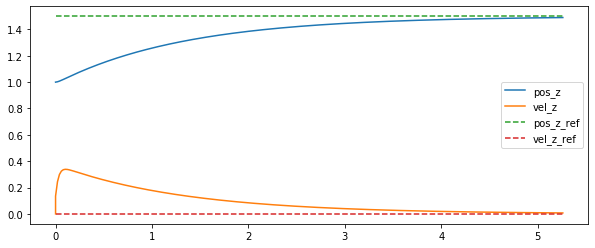

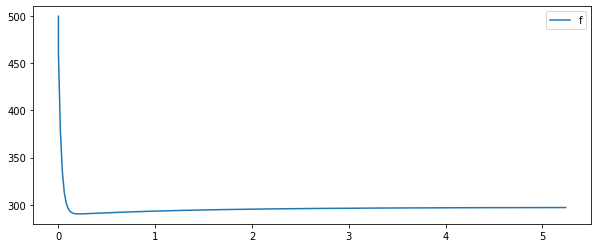

In [23]:
from casadi import *

dt = 1/50 # [s] (sampling time interval)
N = 50

f_min = -500
f_max = 500

p = SX.sym('p') # position state
v = SX.sym('v') # velocity state
g_constant = SX.sym('g') # gravity state / constant (is augmented to allow state space form), might be seperated again for readability

states = [p, v, g_constant]
n = len(states)

f = SX.sym('f') # force input in Z direction
controls = [f]
m = len(controls)

U = SX.sym('U', m, N) # Control action matrix (that will be determined by the NLP solver)
X = SX.sym('X', n, N + 1) # State Matrix (that will also be determined by the NLP solver due to the chosen multiple-shooting method). The + 1 is for x0
P = SX.sym('P', n + n) # Parameter Matrix containing states and reference states

objective_function = 0 # expression for the objective function

# lbx = lower bounds on optimization variable(s)
# ubx = upper bounds on optimization variable(s)
# lbg = lower bounds on constraints vector (should also be a vector), for equality constraints, just set lbg=ubg=k, where k is the constraint value
# ubg = upper bounds on constraints vector (should also be a vector)

lbx = []
ubx = []
lbg = []
ubg = []

g = [] # Constraint vector (both equality and inequality)

g += [X[:,0] - P[0:3]] # equality constraint x0 (chosen by solver) - x0 (input as parameter by user) = 0

lbg += [0, 0, 0]
ubg += [0, 0, 0]

Q = np.array([[100, 0, 0],
              [0, 100, 0],
              [0, 0, 0]]) # no cost / penalty on g

R = np.identity((1)) * 0.0001

A_c = np.array([[0, 1, 0],
                [0, 0, 1],
                [0, 0, 0]])
    
B_c = np.array([[0],
                [1/m_value],
                [0]])

A_d, B_d = discretize_ss(A_c, B_c, dt)

for i in range(0, N):
    #print("i:", i)
    
    state = X[:, i] # extract state at current time step
    control = U[:, i] # extract control input at current time step
    
    # Add the symbolic cost for each time step to the objective function 
    objective_function = objective_function + (state - P[3:6]).T @ Q @ (state - P[3:6]) + control.T @ R @ control
    
    #This is the equality constraint required for multiple shooting, so that the solver respects the system dynamics
    
    next_state = X[:, i+1]
    next_state_simulation = A_d @ state + B_d @ control
    #print("next_state_simulation:", next_state_simulation)
    #print("next state simulation type:", type(next_state_simulation))
    
    g += [next_state - next_state_simulation]
    
    lbg += [0, 0, 0]
    ubg += [0, 0, 0]

optimization_variables = [X.reshape((n * (N+1), 1)), U.reshape((m * N, 1))]

t = 0

x_t = [1, 0, -9.81]

x_ref = [1.5, 0, -9.81]

nlp = {'x':vertcat(*optimization_variables), 'f':objective_function, 'g':vertcat(*g), 'p':P}

opts = {}
opts["print_time"] = 0
opts['ipopt'] = {"max_iter":2000, "print_level":0, "acceptable_tol":1e-8, "acceptable_obj_change_tol":1e-6}

solver = nlpsol('solver', 'ipopt', nlp, opts);

state_history = [x_t]
optimal_state_history = []
optimal_control_history = []
control_history = []
t_history = [t]

# Initialization values for solver. These should be filled with at least a linear interpolation between initial and desired state to improve performance.
# They are updated every iteration.

#U_t = np.zeros((m, N))
#X_t = np.tile(x_t, N+1)

U_t = DM.zeros((m, N))
X_t = DM.zeros((n, N+1))

simulation_time = 10 # [s]

iterations = 0

for i in range(0, n * (N+1) + m * N): # TODO: Add state and input constraints
        
    if i < 32:
        lbx += [-inf]
        ubx += [inf]
    else:
        lbx += [f_min]
        ubx += [f_max]
    
while (abs(x_t[0] - x_ref[0])) > 0.01 and t < simulation_time and True:
    #print("Iteration:", iterations)
    
    x0_solver = vertcat(*[X_t.reshape((n * (N+1), 1)), U_t.reshape((m * N, 1))])
    sol = solver(x0=x0_solver, lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg, p=vertcat(*[x_t, x_ref]))

    X_t = sol['x'][0: n * (N+1)]
    U_t = sol['x'][n * (N+1):]
    #print(type(U_t))
    #print(type(X_t))
    #print("X_t:", X_t)
    #print("U_t:", U_t)
    #print(sol['x'].shape)

    t_history.append(t)
    optimal_state_history.append(X_t)
    optimal_control_history.append(U_t)
    
    x_t = A_d @ np.array(x_t).reshape(3,1) + B_d @ np.array(U_t[0]).reshape(1,1)
    #print(type(x_t))
    x_t_test = DM.zeros((3,1))
    x_t_test[0] = x_t[0]
    x_t_test[1] = x_t[1]
    x_t_test[2] = x_t[2]
    
    #x_t = x_t_test
    
    x_t = DM(x_t)
    
    #print(x_t)
    
    state_history.append(x_t)
    control_history.append(U_t[0])
    
    #print("Distance to reference state:", x_t[0] - x_ref[0])

    t += dt
    iterations += 1
    
print("Final MPC iterations:", iterations)
print("Steady state error:", state_history[-1][0] - x_ref[0])

    
plt.rcParams['figure.figsize'] = [10, 4]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history, [x[0] for x in state_history],label="pos_z")
ax.plot(t_history, [x[1] for x in state_history],label="vel_z")
ax.plot(t_history, np.ones(len(t_history)) * x_ref[0], label="pos_z_ref", linestyle='--')
ax.plot(t_history, np.ones(len(t_history)) * x_ref[1], label="vel_z_ref", linestyle='--')
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_history[:-1], [x[0] for x in control_history], label="f")
plt.legend()